# QLOQ (Qubit Logic on Qudits) – A Hands-On Tutorial

Welcome to this tutorial, where we explore **QLOQ** (Qubit Logic on Qudits) for linear optical quantum computing. We will break down the core concepts behind encoding multiple qubits into a single photon (qudit), demonstrate how **intra-group** gates (like CNOT and single-qubit rotations) are implemented **without** the usual success-probability issues, and show how **Ralph CZ** gates can link multiple qudit blocks.

## References

[1] L. Lysaght, T. Goubault, P. Sinnott, S. Mansfield, P-E. Emeriau, "Quantum circuit compression using qubit logic on qudits," https://arxiv.org/abs/2411.03878v1 (2024).


## Contents

1. [Introduction to QLOQ]
2. [Qudits & CNOT in a Single Photon]
3. [Applying Rotations in a Qudit Group]
4. [Building QLOQ Circuits with Perceval]
5. [Summary]




## 1. Introduction to QLOQ

**QLOQ** (Qubit Logic on Qudits) is a specialized architecture in linear optics that encodes multiple qubits **within a single photon**. Traditionally, a 2-qubit operation in linear optics involves two separate photons interfering at a beam splitter with a probabilistic success rate. However, **QLOQ** circumvents that for intra-group gates by confining both qubits to one photon’s modes.

- **Inter-group** entangling gates (between different photons) still rely on a *Ralph CZ* gate, which is post-selected (probabilistic). Inter-group entangling gates are accomplished via an unbalanced Ralph CZ to accomplish a multi-controlled Z operation. A balanced Ralph CZ has the same success probability(1/9) for each input state. An **unbalanced** version has different success probability for each input. It was chosen because it performs empirically better than the standard CCCZ and requires less post-selected modes.
- **Intra-group** gates (like CNOT, CZ, single-qubit rotations) become deterministic mode permutations and transformations.

## 2. Qudits & CNOT in a Single Photon

### Qudits
A **qubit** is a 2-level system $|0\rangle$ or $|1\rangle$. A **qudit** extends this to $d$ levels. For a **2-qubit** block, $d = 4$. We treat each logical basis state as a unique optical mode:

$|00\rangle \rightarrow$ mode 0  
$|01\rangle \rightarrow$ mode 1  
$|10\rangle \rightarrow$ mode 2  
$|11\rangle \rightarrow$ mode 3  

A single photon occupying exactly one of these four modes represents any superposition of the 2-qubit space.

### CNOT Within a Qudit
In standard linear optics, a **CNOT** between two separate photons is probabilistic. In QLOQ, if both qubits are in the *same* photon, a CNOT is merely a **mode permutation**:

- $|10\rangle \rightarrow |11\rangle$
- $|00\rangle$ and $|01\rangle$ remain the same

The complete mapping is:

Mode Index | Binary State       | CNOT Output
-----------|--------------------|-------------
0          | $\lvert 00\rangle$ | $\lvert 00\rangle$
1          | $\lvert 01\rangle$ | $\lvert 01\rangle$
2          | $\lvert 10\rangle$ | $\lvert 11\rangle$
3          | $\lvert 11\rangle$ | $\lvert 10\rangle$

This operation is **deterministic** because it's implemented entirely within the single photon's modes, bypassing the usual success probability constraints.

> **CZ** is similarly done by a mode permutation + Hadamards on the target qubit.

## 3. Applying Rotations in a Qudit Group
When **multiple qubits** are encoded into a **single photon** (a qudit), each logical qubit corresponds to a specific **pairing of modes**. For a **2-qubit** group (4 modes total):

- **Modes**:  
  $0 \rightarrow |00\rangle$  
  $1 \rightarrow |01\rangle$  
  $2 \rightarrow |10\rangle$  
  $3 \rightarrow |11\rangle$

- **Second qubit** flips between $|0\rangle$ and $|1\rangle$ in the *rightmost bit*, so to rotate it, we **pair**:
  - $(0,1) \rightarrow |00\rangle, |01\rangle$
  - $(2,3) \rightarrow |10\rangle, |11\rangle$

- **First qubit** flips in the *leftmost bit*, so to rotate it, we **pair**:
    - $(0,2) \rightarrow |00\rangle, |10\rangle$
    - $(1,3) \rightarrow |01\rangle, |11\rangle$

- So in practice we would apply a 2 mode parametrized beamsplitter for the specific rotation we want to achieve ($R_x$, $R_y$, $R_z$ etc) for each combination corresponding to the qubit we wish to act on.

- Thankfully all this logic and all relevant swaps have been pre-coded into the ansatz builder so the user need not worry too much about them.

> **Key Insight**: **Intra-group operations** are layerwise, meaning you stack them: first apply a rotation on the second qubit via parametrized beamsplitters on the correct pairs of modes, then do some internal mode swap, then apply a rotation on the first qubit by doing similarly, etc.

## 4. Building QLOQ Circuits with Perceval

Perceval provides a `QLOQ ansatz` that helps you define:

1. **Group Sizes**: e.g., `[Encoding.QUDIT2, Encoding.QUDIT2]`
    - can do Encoding.DUAL_RAIL, Encoding.QUDIT3 etc
2. **Layers**: e.g., `["Y"]` for Ry rotations
3. **Phases**: the numerical angles for each rotation (or `None` for symbolic)
4. **Entangling Gate** (`ctype`): either `"cx"` or `"cz"` inside each group

Below is a minimal code snippet showing how to construct a QLOQ circuit (as a `Processor`) and display it.

In [1]:
from perceval import LogicalState, pdisplay, catalog, Encoding
import perceval as pcvl
import numpy as np
from scipy.optimize import minimize
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt

Number of required phases: 16


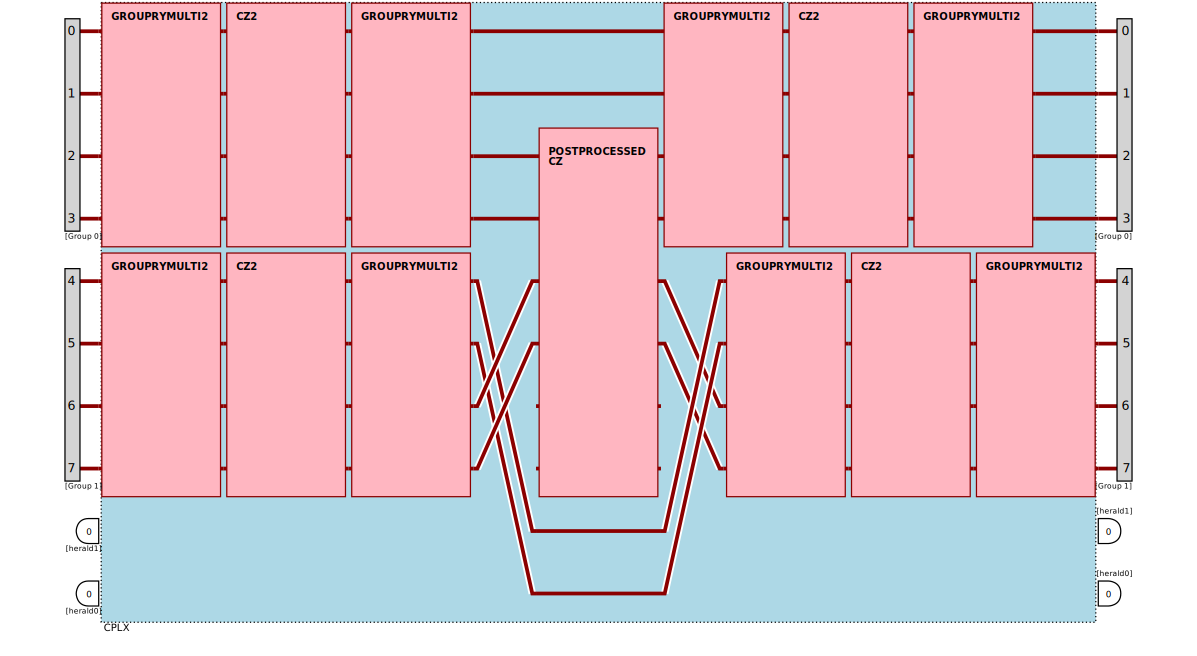

In [2]:
# Example: Building a QLOQ circuit in Perceval
# 1) Get the QLOQ ansatz from Perceval's catalog
ansatz = catalog["qloq ansatz"]

# 2) Define groups of qubits (each group is a qudit)
#    For demonstration: one 2-qubit group (QUDIT2) + another 2 qubit group
group_sizes = [Encoding.QUDIT2, Encoding.QUDIT2]

# 3) Choose the single-qubit rotation layers we want (Y, X, or Z)
layers = ["Y"]  # e.g., apply RY rotations in each group
#generally RY rotations are sufficient

# 4) Compute how many parameter phases are needed
nb_phases = ansatz.get_parameter_nb(group_sizes, len(layers))
print("Number of required phases:", nb_phases)

# 5) (Optional) Provide numeric phases or use None for symbolic placeholders
phases = None  # Use symbolic parameters for visualization

# 6) Build the QLOQ processor with 'ctype="cx"'
circ = ansatz.build_processor(
    group_sizes=group_sizes,
    layers=layers,
    phases=phases,
    ctype="cz"
)

# 7) Display the resulting circuit
pdisplay(circ, recursive=True)

The ansatz in the qubit picture will then have this form where layers of 2 qubit blocks linked by a multi-controlled Z gate which takes the form of a CCCZ here.

![qloqansatz.png](../_static/img/qloqansatz.png)

## 6. Summary

**QLOQ** offers a unique way to encode **multiple qubits** in **one photon** (creating qudits). The major advantage is that **CNOTs and single-qubit rotations** within that qudit can be executed deterministically without the usual success probability of two-photon gates. When linking multiple qudit blocks, **Ralph CZ** gates are used, which are **probabilistic** and post-selected.

### Key Points
- **Qudits**: 2 qubits = 4 modes in a single photon, 3 qubits = 8 modes, etc.
- **Intra-group** gates (e.g., CNOT, Ry, Rz, Rx → Mode permutations and layers of beamsplitters.
- **Inter-group** gates → Ralph CZ (post-selected) forming an unbalanced multi-controlled Z.
- **Layerwise approach**: We apply rotations/cnot gates in a sequence of “layers,” possibly swapping modes to target the correct qubit.

In upcoming sections, we will:
- **Integrate** a classical optimizer (e.g., COBYLA) to do VQE-like or QAOA-like tasks on these QLOQ circuits.
- Explore **QUBO** matrices and measure the resulting cost function from the photonic simulator.

## Encoding Functions Explained

These two functions, `to_fock_state` and `fock_to_qubit_state`, convert between:

1. A **bitstring representation** of qubits (e.g., `"0101"`)
2. A **Fock-state representation** (a list of occupation numbers, eventually wrapped in a `pcvl.BasicState`)

### Key Idea
- **Bitstring**: Represents qubits in the usual binary sense, e.g. `"00"` or `"01"`.
- **Fock State**: In Perceval, a `BasicState` is a list of photon occupation numbers for each mode. A single photon occupying one of $2^n$ possible modes (for an $n$-qubit group) is stored as a one-hot vector (e.g., `[0,1,0,0]` for mode 1 out of 4).

These functions handle situations where **multiple groups** of qubits are each encoded in a **qudit**. For example:

- A group of **size=2** means 4 modes
- A group of **size=3** means 8 modes, etc.

In [3]:
def fock_to_qubit_state(fock_state: List[int], group_sizes: List[int]) -> Optional[str]:
    """
    Convert a Perceval Fock-state representation back to a multi-qubit bitstring.

    Args:
        fock_state: a one-hot vector for all groups (concatenated)
        group_sizes: each integer indicates how many qubits are in that group

    Returns:
        A bitstring (e.g. "0101"), or None if the Fock state is invalid.
    """

    fock_state = [i for i in fock_state]

    # Expected total length = sum of (2^group_size) for each group
    expected_length = sum([2 ** size for size in group_sizes])
    if len(fock_state) != expected_length:
        return None

    offset = 0
    qubit_state_binary = ""

    for size in group_sizes:
        group_length = 2 ** size
        group_fock_state = fock_state[offset : offset + group_length]

        # We expect exactly one '1' in the chunk (indicating the photon mode)
        if group_fock_state.count(1) != 1:
            return None

        state_index = group_fock_state.index(1)
        # Convert index to binary (of width 'size' bits)
        binary_state = format(state_index, f'0{size}b')
        qubit_state_binary += binary_state

        offset += group_length

    return qubit_state_binary

### How `fock_to_qubit_state` Works

1. **Check** the total length needed: sum of $(2^{\text{group\_size}})$
2. **Slice** each group's chunk out of the big `fock_state`
3. Within that chunk, ensure exactly **one** entry is `1`
4. The **index** of that `1` is the integer representation of the bits for that group
  - Convert that index to a binary string of width `n`
5. Append all these binary substrings together, forming the **full** qubit bitstring

#### Example 
- `fock_state = [1,0,0,0, 0,0,0,1]` (length=8)
- `group_sizes = [2,2]`

**Step by Step**:

- Group A chunk: `[1,0,0,0]` → exactly one '1' at index=0 → binary of `0` with width=2 → `"00"`
- Group B chunk: `[0,0,0,1]` → index=3 → binary= `"11"`

Concatenate = `"00" + "11"` = `"0011"`

## Edge Cases

1. **Invalid Fock State**
  If a chunk has more than one `1` or none at all, `fock_to_qubit_state` returns `None`.
  This ensures we only accept states with exactly **one** photon per group.
  Thus, we have post-selected

2. **Bitstring Offsets**
  The variable `offset` keeps track of how many bits we've already consumed from `qubit_state`.
  This ensures we map each portion of the bitstring to its corresponding qudit group.

---

By using the helper function:

- `fock_to_qubit_state`: you can interpret the circuit's **measurement results** (a one-hot outcome) back into a **bitstring** for classical post-processing or optimization

## QUBO Example with a Simple QLOQ ansatz Circuit (CVaR-VQE Approach)

In this notebook, we demonstrate how to tackle a **QUBO** (Quadratic Unconstrained Binary Optimization) problem using a **CVar-VQE** style approach in Perceval. This can also be verified with the other more photonic QUBO approach which uses the same QUBO matrix. We’ll show:

1. **Building a simple QLOQ circuit** (e.g., with Ry layers) to produce a variational ansatz.
2. **Sampling** from the circuit to get a distribution of bitstrings.
3. **Computing CVaR** to measure the cost (objective function) and performing classical optimization (COBYLA).
4. **Identifying the best bitstring** based on the final solution.
5. **Optional**: Plotting the final probability distribution as a histogram for visual insight.

## What is CVaR-VQE?

**CVaR-VQE** (Conditional Value-at-Risk Variational Quantum Eigensolver) is a hybrid quantum-classical optimization technique that **goes beyond** the usual average-cost minimization seen in standard VQE:

1. **VQE Recap**
   - In a typical VQE, you prepare a **parametrized quantum circuit** (ansatz).
   - You **sample** from it to estimate the **average** energy (or cost).
   - A **classical optimizer** tunes the circuit parameters to **minimize** this average cost.

2. **Why CVaR?**
   - In many problems, you don’t just care about the **average** cost. You also want to avoid **worst-case** outcomes.
   - **CVaR** (Conditional Value-at-Risk) focuses on the **worst $\alpha$-fraction** of possible outcomes in your distribution.
   - Practically, we *sort* outcomes by cost and *average* the top $\alpha$ portion (highest costs). If $\alpha = 0.5$, that means we look at the top 50% of the distribution by cost. By **minimizing** that portion, we make sure the algorithm consistently avoids very high-cost states.

3. **Combining CVaR with VQE**
   - We still build a **variational circuit** and measure its outputs, but instead of updating parameters to reduce the simple average cost, we **focus on the worst tail**.
   - This ensures the final circuit is **less likely** to produce very bad solutions.

In short, **CVaR-VQE** aims to push the distribution of measured bitstrings toward reliably low-cost outcomes, rather than just optimizing the mean. This can be extremely useful for **QUBO** (Quadratic Unconstrained Binary Optimization) problems, where you want to avoid sampling high-cost bitstrings even occasionally.



In [4]:
def compute_cvar(probabilities: List[float], values: List[float], alpha: float) -> float:
    """
    Compute the Conditional Value at Risk (CVaR).
    Given a list of probabilities and corresponding values (costs),
    we take the worst alpha portion of outcomes and average them
    weighted by their probabilities.
    """
    sorted_indices = np.argsort(values)  # sort by ascending value
    probs = np.array(probabilities)[sorted_indices]
    vals = np.array(values)[sorted_indices]
    cvar = 0
    total_prob = 0

    for p, v in zip(probs, vals):
        if p >= alpha - total_prob:
            p = alpha - total_prob
        total_prob += p
        cvar += p * v

    return cvar / total_prob

def expectation_value(vec_state: np.ndarray, qubo_matrix: np.ndarray) -> float:
    """
    Compute the expectation value for a given state with respect to a QUBO matrix.
    Here, vec_state is a binary vector (e.g., [0,1,0,1]) converted to float,
    and qubo_matrix is the NxN matrix of the QUBO.
    """
    return np.dot(vec_state.conjugate(), np.dot(qubo_matrix, vec_state))

def extract_probability_distribution(job_results: Dict, group_sizes: List[int]) -> Tuple[Dict[str, float], int]:
    """
    Extract probability distribution from sampling results.
    Returns:
      output_dict = {bitstring: probability}
      sum_valid_outputs = sum of all valid counts (used for normalization)
    """
    output_dict = {}
    sum_valid_outputs = 0

    # First pass: count how many valid outputs (bitstrings)
    for res in job_results['results']:
        qb_state = fock_to_qubit_state(res, group_sizes)
        if qb_state:
            sum_valid_outputs += job_results['results'][res]
            output_dict[qb_state] = job_results['results'][res]
            
    divisor = sum_valid_outputs
    output_dict = {k: v/divisor for k, v in output_dict.items()}
    #compute probabilities by dividing by sum

    return output_dict

In [5]:
def build_circuit(phases: List[float], group_sizes: List[int], layers: List[str]) -> pcvl.Circuit:
    """
    Build the quantum circuit (QLOQ ansatz) with specified phases.
   
    """
    ansatz = catalog["qloq ansatz"]
    group_sizes_p = [Encoding.DUAL_RAIL if x == 1 else eval(f"Encoding.QUDIT{x}") for x in group_sizes]
    proc = ansatz.build_processor(
        group_sizes=group_sizes_p,
        layers=layers,
        phases=phases,
        ctype="cz" #can be cx too
    )
    return proc

In [6]:
def create_objective_function(qubo_matrix: np.ndarray,
                              input_state: str,
                              group_sizes: List[int],
                              layers: List[str],
                              sampling_size: int,
                              alpha: float,
                              verbose):
    """
    Create the CVaR-VQE objective function for optimization.
    - qubo_matrix: the QUBO cost matrix
    - input_state: initial computational basis string (e.g. "000000")
    - group_sizes: list of integers, each representing # of qubits in that group
    - layers: e.g. ["Y"] or ["Y","X"]
    - sampling_size: how many shots to gather per evaluation
    - alpha: the fraction for CVaR computation

    Returns:
      objective_function (callable): to be passed into an optimizer
      best_result (list reference): to track the best (lowest) loss + best bitstring
    """
    best_result = [None]  # store (loss, bitstring)
    iteration = [0]       # track iteration count

    def objective_function(phases: np.ndarray) -> float:
        # Build circuit (processor)
        circ = build_circuit(phases.tolist(), group_sizes, layers)
        circ.with_input(LogicalState(input_state))
        
        # Sample from the circuit
        sampler = pcvl.algorithm.Sampler(circ, max_shots_per_call=sampling_size)
        job_results = sampler.sample_count(sampling_size)

        # Extract distribution
        output_dict = extract_probability_distribution(job_results, group_sizes)
        if not output_dict:
            return float('inf')  # if no valid results, large penalty

        # Convert bitstrings to vectors => compute QUBO cost => gather CVaR
        probabilities = list(output_dict.values())
        values = [expectation_value(np.array(list(state)).astype(int), qubo_matrix)
                  for state in output_dict.keys()]

        loss = compute_cvar(probabilities, values, alpha)

        # Track the best result
        bitstring = max(output_dict, key=output_dict.get)
        if best_result[0] is None or loss < best_result[0][0]:
            best_result[0] = (loss, bitstring)

        iteration[0] += 1
        if verbose == True:
            print(f"Iteration {iteration[0]}: Loss = {loss}, Best bitstring = {bitstring}")

        return loss

    return objective_function, best_result

In [7]:
def optimize_qubo(qubo_matrix: np.ndarray,
                  input_state: str,
                  group_sizes: List[int],
                  layers: List[str],
                  sampling_size: int = 100000,
                  alpha: float = 0.5,
                  maxiter: int = 50,
                  verbose=False) -> Tuple[float, str, np.ndarray]:
    """
    Run the optimization using COBYLA to find phases that minimize CVaR for the given QUBO problem.
    - qubo_matrix: your QUBO cost matrix
    - input_state: initial bitstring
    - group_sizes: e.g. [2,2,2]
    - layers: e.g. ["Y"]
    - sampling_size: how many shots per circuit evaluation
    - alpha: fraction for CVaR
    - maxiter: max COBYLA iterations

    Returns:
      final_loss (float): best CVaR found
      best_bitstring (str): best measured bitstring
      optimal_phases (np.ndarray): the phase vector that achieved the best result
    """
    ansatz = catalog["qloq ansatz"]
 
    group_sizes_p = [Encoding.DUAL_RAIL if x == 1 else eval(f"Encoding.QUDIT{x}") for x in group_sizes]
    nb_phases = ansatz.get_parameter_nb(group_sizes_p, len(layers))

    # Random initial guess for the phases
    initial_phases = np.random.uniform(0, 2*np.pi, nb_phases)

    # Build the objective function
    objective_function, best_result = create_objective_function(
        qubo_matrix, input_state, group_sizes, layers, sampling_size, alpha, verbose=verbose)

    # Minimize
    result = minimize(
        objective_function,
        initial_phases,
        method='cobyla',
        options={
            'maxiter': maxiter,
        }
    )

    best_loss = result.fun
    best_bitstring = best_result[0][1]
    return best_loss, best_bitstring, result.x

In [8]:
def plot_bitstring_distribution(prob_dict: Dict[str, float], top_n: int = 10, title: str = "Top Bitstring Probabilities"):
    """
    Plot a histogram of the top N most probable bitstrings.

    Args:
        prob_dict: e.g. {"000000": 0.25, "100100": 0.15, ...}
        top_n: how many top states to display
        title: plot title
    """
    # Convert dict to list of (bitstring, probability) pairs
    items = list(prob_dict.items())

    # Sort descending by probability
    items.sort(key=lambda x: x[1], reverse=True)

    # Take the top 'top_n' states
    items = items[:top_n]

    # Unzip into two lists
    bitstrings, probs = zip(*items)

    plt.figure(figsize=(8, 4))
    plt.bar(bitstrings, probs, color='darkviolet')
    plt.ylabel("Probability")
    plt.xlabel("Bitstring")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

## Putting It All Together

Below is a complete **example** usage, showing how to:

1. Define a sample QUBO matrix (6-qubit problem).
2. Optimize using Ry layers in a QLOQ circuit.
3. Print the final result and best bitstring.
4. Optionally, sample the final circuit once more to plot the output distribution.


=== Final Optimization Results ===
Final CVaR Loss: -28.0
Best Bitstring: 100100
Optimal Phases: [4.200837   1.62670822 0.36482508 1.18591695 3.88281078 5.25753628
 0.72775691 6.69114885 0.76392658 3.89528128 6.98317503 3.82909631
 1.13037017 5.36749091 2.59795026 3.46961516 1.82192932 2.77550708
 0.70081262 1.62864774 0.04678577 1.33450755 3.13244617 5.03153063]


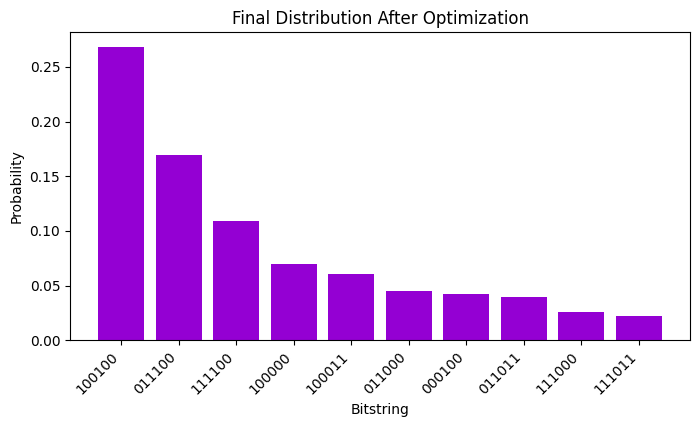

In [9]:
# Example QUBO matrix (6-qubit), taken from the other QUBO notebook
H1 = np.array([
    [2.,   32., -32., -32.,  32.,   0.],
    [0.,    1.,  32.,   0., -32., -32.],
    [0.,    0.,  35.,  32., -64., -32.],
    [0.,    0.,   0.,   2., -32.,  32.],
    [0.,    0.,   0.,   0.,  35.,  32.],
    [0.,    0.,   0.,   0.,   0.,   4.]
])

# We'll group the 6 qubits into 2 groups of 3 qubits each: [3,3]
# these combinations are also possible [2,2,2], [5,1], [4,2], [3,1,1] etc
# different group combinations may have different alpha value or sample number needs so play around with different hyperparameters
group_sizes = [3,3]

# Single rotation layer: ["Y"]
layers = ["Y"]

# Run the optimization
final_loss, best_bitstring, optimal_phases = optimize_qubo(
    qubo_matrix=H1,
    input_state="000000",     # e.g. 6-qubit input in |000000>
    group_sizes=group_sizes,
    layers=layers,
    sampling_size=10000000,    # how many shots for sampling
    alpha=0.25,                # CVaR parameter
    maxiter=600,
    verbose=False  # displays iterations results if set to True
)

print("\n=== Final Optimization Results ===")
print(f"Final CVaR Loss: {final_loss}")
print(f"Best Bitstring: {best_bitstring}")
print(f"Optimal Phases: {optimal_phases}")

# Sample final circuit with the found phases, then plot the output distribution
circ = build_circuit(list(optimal_phases), group_sizes, layers)
circ.with_input(LogicalState("000000"))
sampler = pcvl.algorithm.Sampler(circ, max_shots_per_call=10000000)
job_results = sampler.sample_count(10000000)

output_dict = extract_probability_distribution(job_results, group_sizes)
plot_bitstring_distribution(output_dict, title="Final Distribution After Optimization")

### Explanation

1. `optimize_qubo` calls our **objective function** repeatedly, adjusting phases to reduce the **CVaR** of the QUBO cost.
2. `alpha` in **CVaR** picks how much “worst tail” of outcomes we average over. $\alpha = 0.5$ is a middle ground.
3. `best_bitstring` is chosen from the final distribution’s highest-probability outcome (in practice, you might also check the distribution).
4. The **plot** helps visualize which bitstrings are being sampled at the end of optimization.

---

With this approach, you have a working **CVaR-VQE** routine for **QUBO** problems using an ansatz in the **QLOQ** framework. You can expand this by:
- Increasing the number of **layers** (e.g., `["Y","X"]`).
- Using **CX** gates instead of CZ inside groups (`ctype="cx"`).
- Changing **group_sizes** or QUBO matrix to match your real problem.
- Exploring advanced optimization methods or different cost functions beyond QUBO.

This completes our demonstration of a **QUBO** problem solved by a **CVar-VQE**-like approach in **Perceval’s QLOQ** environment. QLOQ can be applied to various problems involving a variational circuit so it is recommended to refactor this example to your needs whether by changing the loss function to match your given problem or the circuit structure itself.